# Analysis of exploratory behaviour aligned to onset

## Exploration of population vector and temporal profile of activity matrix aligned to onset

## and explotation of signal and noise correlation matrix for different events aligned to onset

''' Created on Wed 28 April 2021'''


In this notebook we will analyze periods of ethogram exploration as classifyed with DLC. 

First we will extract the pre and post onset signal, aligned to the time when the events start. We will compute a mean population vector in the vecinity of the onset, and then analyze the full data by computing the signal correlation matrix and the noise correlation matrix. 

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import scipy
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32363         ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 1
period = int(3 * sf / re_sf)
fixed = 'None'

## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)
    
    behaviour_list.append(resample_beh1)
    total_time = total_time + behaviour.shape[0]
    
    
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    day = day + 1

In [5]:
## define targets of behaviour according to protocol (random, overlapping and stable)

id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2

if colapse_behaviour == 0 : # RANDOM
    for day in range(len(behaviour_list)):
        for trial in range(5):
            behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
            objects = np.unique(behaviour_trial)
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_trial==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
            behaviour_trial[index0] = 3
            behaviour_trial[index1] = 4
            behaviour_trial[index2] = 4            
            
            index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
            behaviour_trial[index0] = 5
            behaviour_trial[index1] = 6
            behaviour_trial[index2] = 6 
            
            behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


if colapse_behaviour == 1 : #OVERLAPPING
    for day in range(len(behaviour_list)):
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
        behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
        behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


if colapse_behaviour == 2: #STABLE
    for day in range(len(behaviour_list)):
        objects = np.unique(behaviour_list[day])
        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
        index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
        behaviour_list[day][index0] = 3
        behaviour_list[day][index1] = 4
        behaviour_list[day][index2] = 4      
    
        index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
        behaviour_list[day][index0] = 5
        behaviour_list[day][index1] = 6
        behaviour_list[day][index2] = 6  

In [6]:
# for each day creates a list that counts and saves times of different events.
events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1
    events_day_list.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [7]:
## put all events together and take neural activity from each event
events_activity_pre_norm= []
for day in range(len(behaviour_list)):
    target_activity = []
    for target in id_target:
        events = np.array(events_day_list[day])
        events_counter = np.array(events_counter_day_list[day])
        events_time = np.array(events_time_starts_day[day])

        position_events = np.where(events == target)[0]
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        event_target = []
        for event in events_duration:
            if event > 0:
                local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                event_target.append(local_activity)
            i = i + 1
        target_activity.append(event_target)
    events_activity_pre_norm.append(target_activity)

In [25]:
# z-score the traces
events_activity = []
for day in range(len(behaviour_list)):
    target_activity = []
    for target in id_target:
        mean_z_score = np.mean(events_activity_pre_norm[day][target],axis=0)
        #print(mean_z_score.shape)
        std_z_score = np.std(events_activity_pre_norm[day][target],axis=0)
        events_target = []
        for event in range(len(events_activity_pre_norm[day][target])):
            new_activity = (events_activity_pre_norm[day][target][event]-mean_z_score)/std_z_score
            events_target.append(new_activity)
        target_activity.append(events_target)
    events_activity.append(target_activity)

In [26]:
#events_activity = events_activity_pre_norm

In [27]:
# compute the mean and z-score the traces
mean_over_events = []
for day in range(len(behaviour_list)):
    mean_over_events_day = []
    for target in id_target:
        mean_events = np.mean(np.array(events_activity[day][target]),axis = 0)
        mean_over_events_day.append(mean_events)
    mean_over_events.append(mean_over_events_day)

temporal_profile = []
pop_vector = []
for day in range(len(behaviour_list)):
    temporal_profile_day = []
    pop_vector_day = []
    for target in id_target:
        temporal_profile_day.append(np.mean(mean_over_events[day][target],axis=0))
        pop_vector_day.append(np.mean(mean_over_events[day][target],axis=1))
    temporal_profile.append(temporal_profile_day)
    pop_vector.append(pop_vector_day)

plotting
[-3.12481180e-17 -2.18335222e-17 -2.25821991e-19  8.09366545e-18
  8.81090689e-18 -2.87409807e-18]
[-6.37698786e-18 -8.33720221e-18  1.13186485e-17 -1.94000295e-17
 -1.49158405e-17 -1.52755167e-17]
[-4.71620543e-17  6.69150631e-18 -1.86013627e-17  7.91567929e-18
 -2.55940144e-17 -1.73605919e-17]
[ 2.41701563e-17  2.17718331e-18  1.67262693e-17  6.10979945e-18
  5.80137922e-17 -6.88842611e-18]
[ 6.39139634e-18  3.54073334e-17  8.43692695e-18  3.62038993e-17
 -1.90961476e-17 -9.35561187e-18]
[ 7.18866671e-19 -3.91048414e-18 -2.00536557e-17  1.52177505e-18
 -1.26604020e-17 -2.44914214e-17]
[5.59329993e-18 2.40694308e-17 2.82621069e-17 2.43068718e-18
 1.12483302e-17 1.04403466e-17]


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


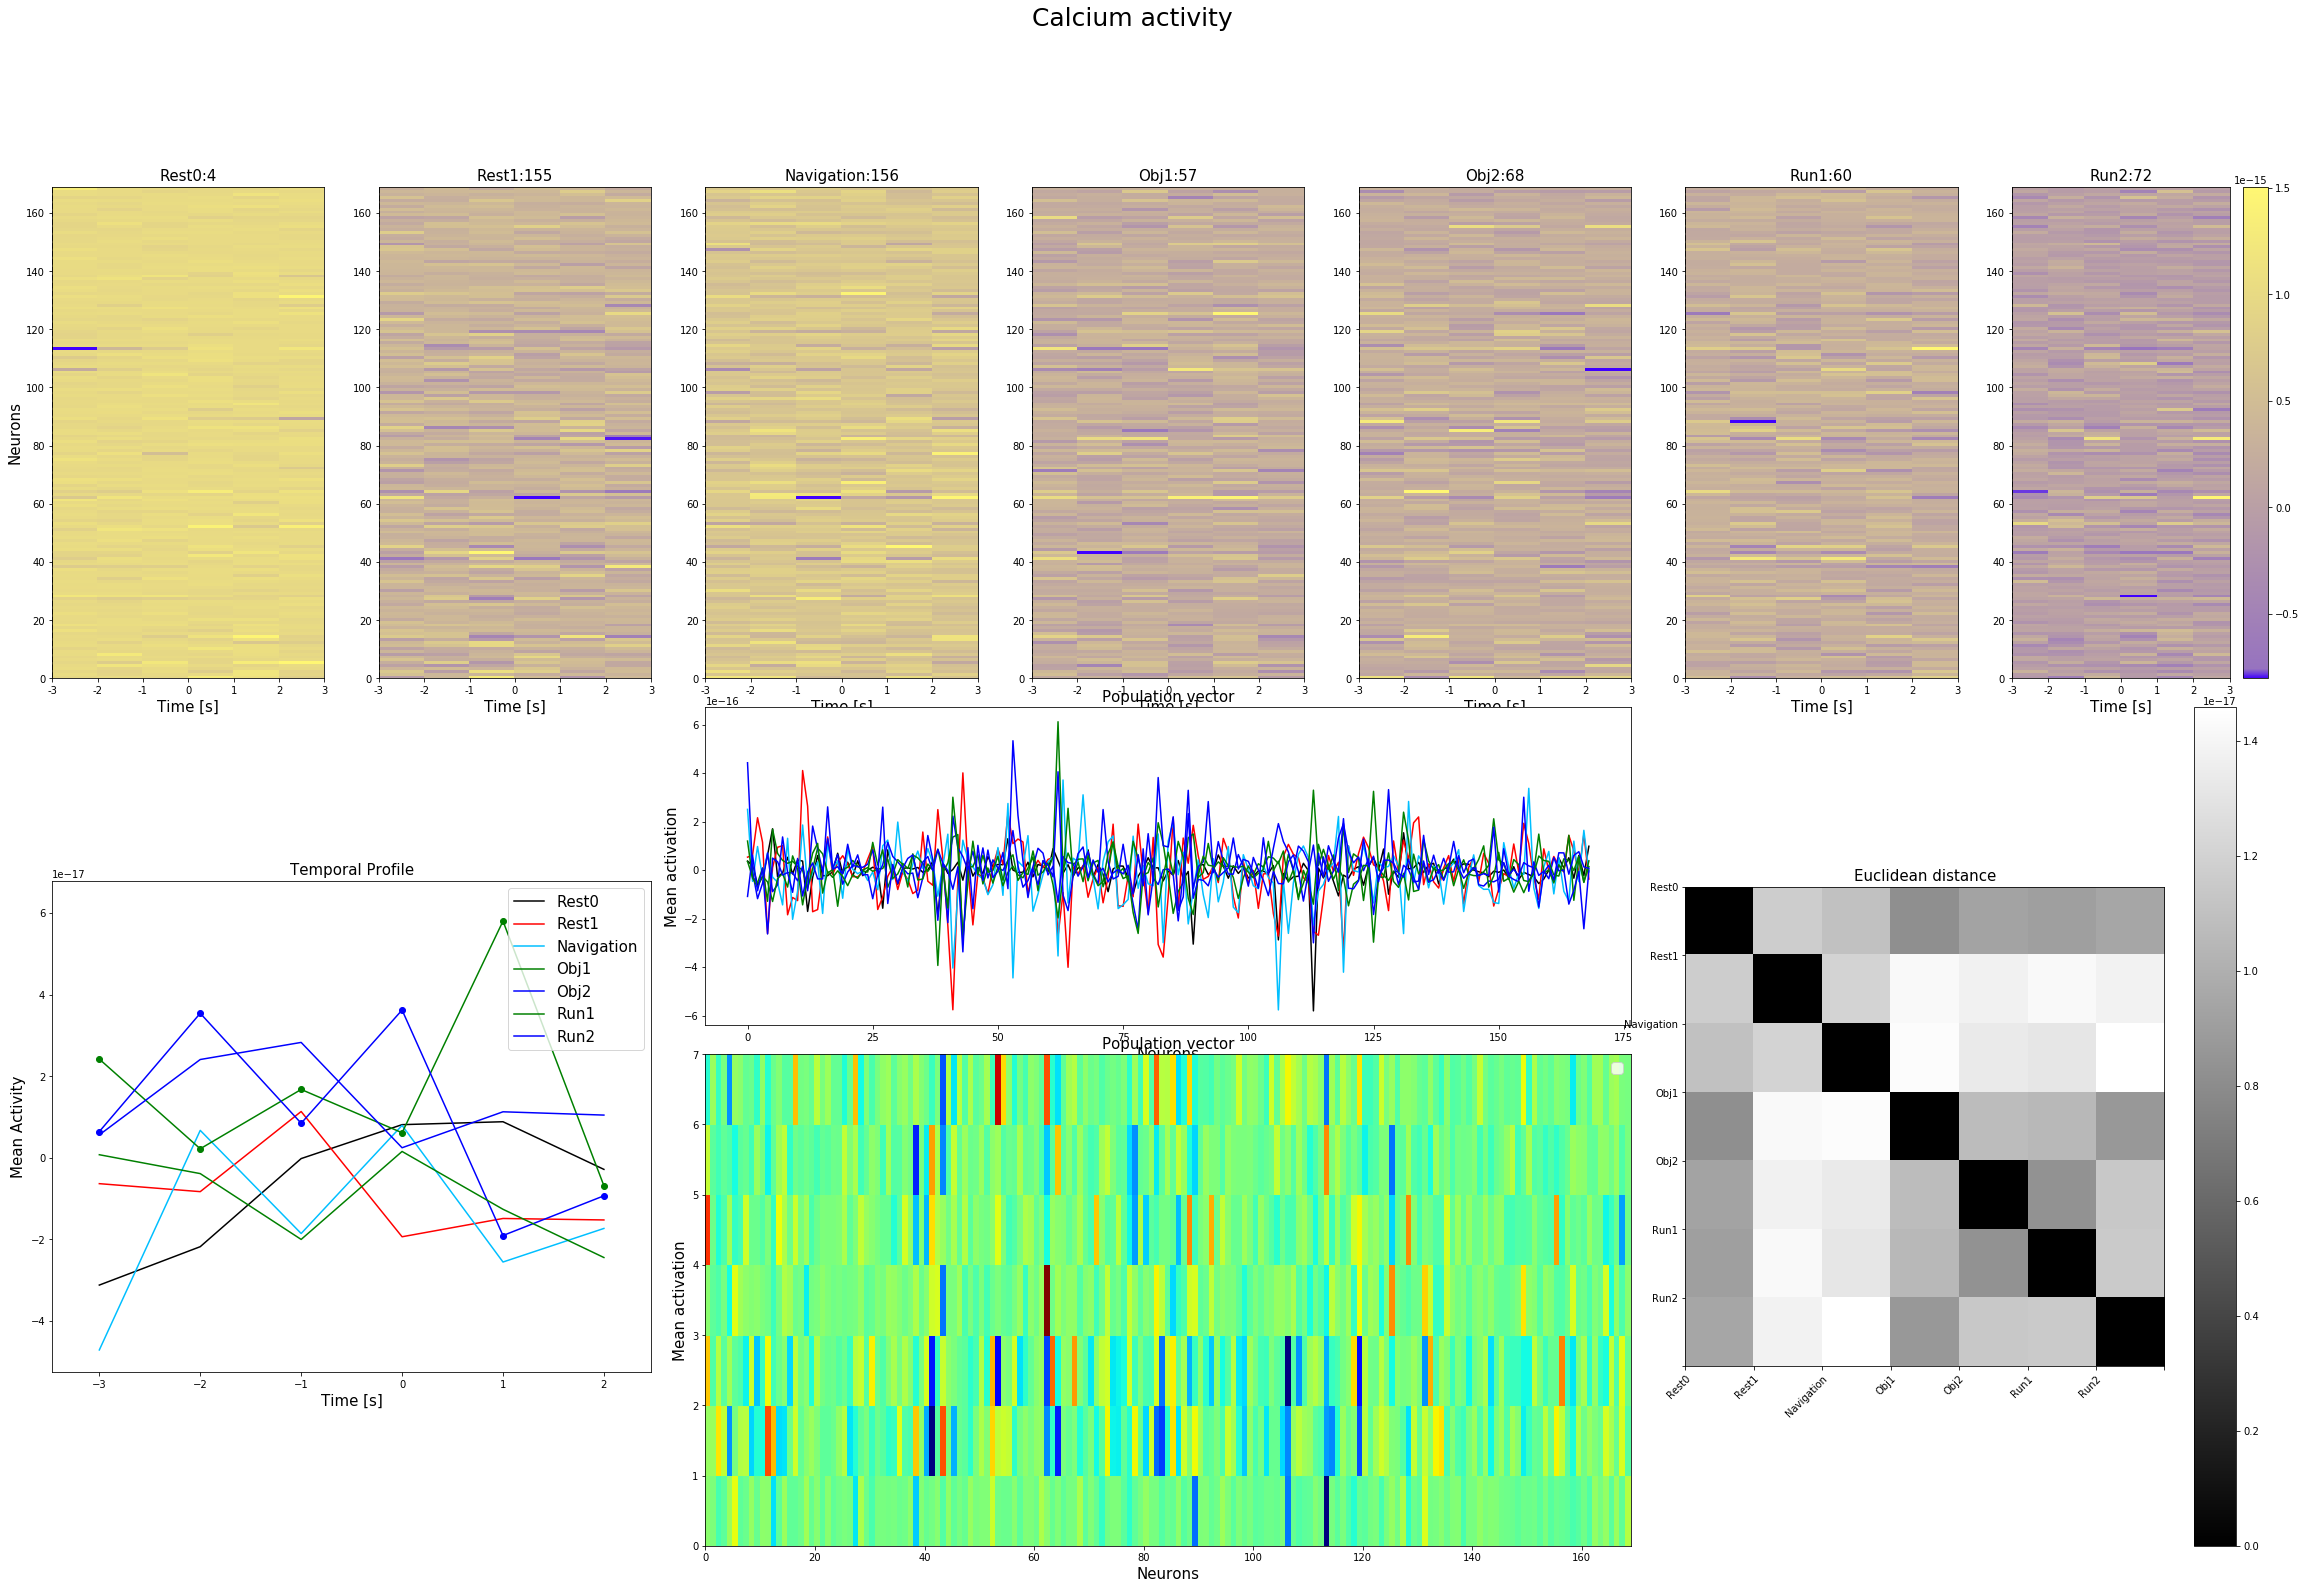

In [28]:

     
print('plotting')
import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

day = 0
#vmin= 0
#vmax=4

fig = plt.figure()
gs = plt.GridSpec(8, 7)

x_axes = np.array([-3,-2,-1,0,1,2,3])
for i in range(1):
    for j in range(8):
        if i*2+j < 7:
            ax = fig.add_subplot(gs[0:3, j])
            ax.set_title(labels[i*1+j]+':'+ f'{len(events_activity[day][i*1+j])}' , fontsize = 15)
            if i*2+j == 0:
                ax.set_ylabel('Neurons', fontsize = 15)
            ax.set_xlabel('Time [s]', fontsize = 15)
            mesh = ax.pcolormesh(mean_over_events[day][i*2+j], cmap = cm)
            #mesh.set_clim(vmin,vmax)
            ax.set_xticks(np.arange(0,len(x_axes)))
            ax.set_xticklabels(x_axes)
            ax.vlines(0,0,mean_over_events[day][i*4+j].shape[0],colors = 'k', linestyles = 'dashed')

fig.colorbar(mesh,ax=ax)
ax = fig.add_subplot(gs[4:7, 0:2])

for target in id_target:
    ax.plot(x_axes[:-1],temporal_profile[day][target], color = colornames[target])
    print(temporal_profile[day][target])
ax.legend(labels, fontsize = 15)

for target in [3,4]:
    ax.scatter(x_axes[:-1],temporal_profile[day][target], color = colornames[target])
#ax.vlines(0,-0.2,0.2,colors = 'k', linestyles = 'dashed')
ax.set_xlabel('Time [s]', fontsize = 15)
ax.set_ylabel('Mean Activity', fontsize = 15)
ax.set_title('Temporal Profile',fontsize = 15)

ax = fig.add_subplot(gs[3:5, 2:5])
for target in id_target:
    ax.plot(pop_vector[day][target], color = colornames[target])
ax.set_xlabel('Neurons', fontsize = 15)
ax.set_ylabel('Mean activation', fontsize = 15)
ax.set_title('Population vector',fontsize = 15)

ax = fig.add_subplot(gs[5:8, 2:5])
mesh = ax.pcolormesh(pop_vector[day], cmap = 'jet')
#vmin= -3
#vmax=3
#mesh.set_clim(vmin,vmax)
#ax.imshow(pop_vector)
ax.set_xlabel('Neurons', fontsize = 15)
ax.set_ylabel('Mean activation', fontsize = 15)
ax.set_title('Population vector',fontsize = 15)
ax.legend(labels, fontsize = 15)
#fig.colorbar(mesh,ax=ax)


## compute euclidean distance matrix using normalization
euclidean_distance = np.zeros((len(pop_vector[day]),len(pop_vector[day])))
for i in range(0,len(pop_vector[day])):
    for j in range(0,len(pop_vector[day])):
        distance = np.linalg.norm(pop_vector[day][i]-pop_vector[day][j])
        euclidean_distance[i,j]= distance / pop_vector[day][i].shape

ax = fig.add_subplot(gs[3:8, 5:7])
ax.set_title('Euclidean distance', fontsize = 15)
x = ax.imshow(euclidean_distance, cmap = 'gray')
#x.set_clim(0,0.01)
    
x_pos = np.arange(-0.5,len(labels)+0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels(labels)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
      
    
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fig.colorbar(x, ax=ax)
    
fig.tight_layout()
fig.set_size_inches(40,25)
fig.suptitle('Calcium activity', fontsize = 25)

figure_name = figure_path +'calcium_activity_unsorted_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

In [29]:
### sorted by mean firing rate

sorted_mean_over_events = []
signal_corr_matrix = []
noise_corr_matrix = []

signal_corr_flatten = []
noise_corr_flatten = []

for target in id_target:
    mean_firing_rate = np.mean(mean_over_events[day][target], axis = 1)
    positions = np.flip(np.argsort(mean_firing_rate))
    data = mean_over_events[day][target][positions,:]
    non_zero_positions = np.where(np.mean(data,axis=1))
    data_non_zero = data[non_zero_positions,:]
    data_non_zero = data_non_zero[0,:,:]
    sorted_mean_over_events.append(data_non_zero)

    positions1 = positions[np.where(mean_firing_rate[positions])]
    corr_matrix2 = stats.corr_matrix(neural_activity = data_non_zero)
    signal_corr_matrix.append(corr_matrix2)
    signal_corr_flatten.append(np.array(corr_matrix2.flatten().reshape(-1,1)))

    activation = events_activity[day][target]
    matrix = np.zeros((positions1.shape[0],2*period*len(activation)))
    
    for i in range(len(activation)):
        matrix[:,i*2*period:(i+1)*2*period] = activation[i][positions1,:] - mean_over_events[day][target][positions1,:]
    
    corr_matrix = stats.corr_matrix(neural_activity = matrix)
    noise_corr_matrix.append(corr_matrix)
    noise_corr_flatten.append(np.array(corr_matrix.flatten().reshape(-1,1)))


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


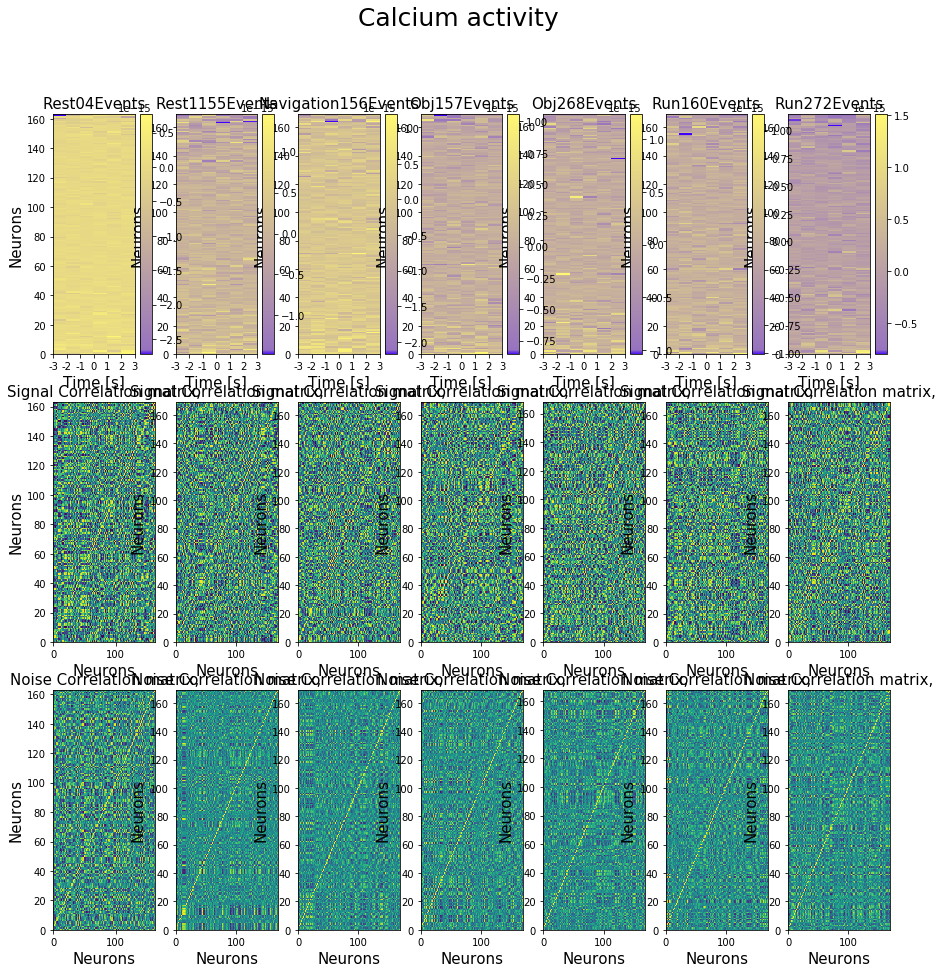

In [30]:


fig, axes = plt.subplots(3,7)

for target in id_target:
    vmin= 0
    vmax=1
    axes[0,target].set_title(labels[target]+ f'{len(events_activity[day][target])}' + 'Events' , fontsize = 15)
    axes[0,target].set_ylabel('Neurons', fontsize = 15)
    axes[0,target].set_xlabel('Time [s]', fontsize = 15)
    mesh = axes[0,target].pcolormesh(sorted_mean_over_events[target], cmap = cm)
    #mesh.set_clim(vmin,vmax)
    axes[0,target].set_xticks(np.arange(0,len(x_axes)))
    axes[0,target].set_xticklabels(x_axes)
    #axes[0,target].vlines(0,0,mean_over_events[i*4+j].shape[0],colors = 'k', linestyles = 'dashed')
    fig.colorbar(mesh,ax=axes[0,target])


    vmin_corr = -1
    vmax_corr = 1
    axes[1,target].set_ylabel('Neurons', fontsize = 15)
    axes[1,target].set_xlabel('Neurons', fontsize = 15)
    axes[1,target].set_title('Signal Correlation matrix,', fontsize = 15)
    mesh3 = axes[1,target].pcolormesh(signal_corr_matrix[target], cmap = 'viridis')
    mesh3.set_clim(vmin_corr,vmax_corr)
    #fig.colorbar(mesh3,ax=axes[1,target])

    axes[2,target].set_ylabel('Neurons', fontsize = 15)
    axes[2,target].set_xlabel('Neurons', fontsize = 15)
    axes[2,target].set_title('Noise Correlation matrix,', fontsize = 15)
    mesh6 = axes[2,target].pcolormesh(noise_corr_matrix[target], cmap = 'viridis')
    mesh6.set_clim(vmin_corr,vmax_corr)
    #fig.colorbar(mesh6,ax=axes[2,target])

fig.tight_layout()
fig.set_size_inches(15,15)
fig.suptitle('Calcium activity', fontsize = 25)

figure_name = figure_path +'calcium_activity_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)


In [31]:
### computing distances

signal_corr_flatten = []
noise_corr_flatten = []

for target in id_target:
    corr_matrix2 = stats.corr_matrix(neural_activity = mean_over_events[day][target])
    signal_corr_flatten.append(np.array(corr_matrix2.flatten().reshape(-1,1)))
    
    activation = events_activity[day][target]
    matrix = np.zeros((activation[0].shape[0],2*period*len(activation)))
    for i in range(len(activation)):
        matrix[:,i*2*period:(i+1)*2*period] = activation[i] - mean_over_events[day][target]
    corr_matrix = stats.corr_matrix(neural_activity = matrix)
    noise_corr_flatten.append(np.array(corr_matrix.flatten().reshape(-1,1)))


In [32]:
### compute distance as cosine similarity between signal and noise corr matrix
signal_cosine_similarity = np.zeros((len(id_target),len(id_target)))
noise_cosine_similarity = np.zeros((len(id_target),len(id_target)))
for target1 in id_target:
    for target2 in id_target:
        signal_cosine_similarity[target1,target2] = cosine_similarity(signal_corr_flatten[target1].T,signal_corr_flatten[target2].T)
        noise_cosine_similarity[target1,target2] = cosine_similarity(noise_corr_flatten[target1].T,noise_corr_flatten[target2].T)
        #signal_cosine_similarity[target1,target2] = np.dot(signal_corr_flatten[target1].T,signal_corr_flatten[target2])

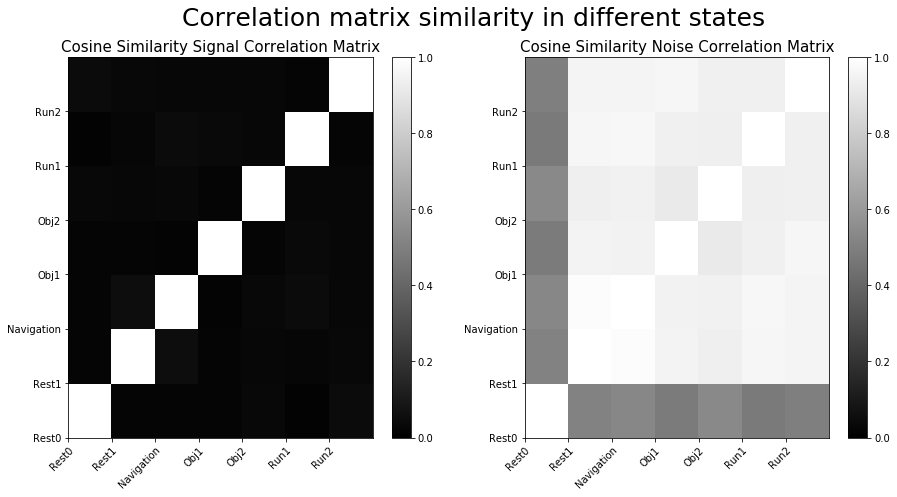

In [33]:
fig, axes = plt.subplots(1,2)
mesh0 = axes[0].pcolormesh(signal_cosine_similarity, cmap = 'gray')
vmin= 0
vmax=1
mesh0.set_clim(vmin,vmax)
fig.colorbar(mesh0,ax=axes[0])
axes[0].set_title('Cosine Similarity Signal Correlation Matrix', fontsize = 15)

mesh1 = axes[1].pcolormesh(noise_cosine_similarity, cmap = 'gray')
vmin= 0
vmax=1
mesh1.set_clim(vmin,vmax)
fig.colorbar(mesh1,ax=axes[1])
axes[1].set_title('Cosine Similarity Noise Correlation Matrix', fontsize = 15)

for i in [0,1]:
    x_pos = np.arange(0,len(labels))
    axes[i].set_yticks(x_pos)
    axes[i].set_yticklabels(labels)
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(labels)
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
fig.set_size_inches(15,7)
fig.suptitle('Correlation matrix similarity in different states', fontsize = 25)

figure_name = figure_path +'Correlation_matrix_signal_and_noise_cosine_similarity_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

In [ ]:
target